In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

In [2]:
train = pd.read_csv('data/train_features.csv')
train_labels = pd.read_csv('data/train_labels.csv')
test = pd.read_csv('data/test_features.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [3]:
train.shape

(1875000, 8)

In [4]:
x_train = []

for uid in tqdm(train['id'].unique()):
    temp = np.array(train[train['id'] == uid].iloc[:,2:], np.float32).T
    x_train.append(temp)

x_train = np.array(x_train, np.float32)
# x_train = x_train[:,:,:,np.newaxis]

x_test = []

for uid in tqdm(test['id'].unique()):
    temp = np.array(test[test['id'] == uid].iloc[:,2:], np.float32).T
    x_test.append(temp)

x_test = np.array(x_test, np.float32)
# x_test = x_test[:,:,:,np.newaxis]

100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:13<00:00, 58.70it/s]


In [5]:
def aug(data, uid, shift = 0):
    shift_data = np.roll(data, shift, axis=2)
    return shift_data

In [6]:
shift_data = aug(x_train, 0 , int(random.random()*600))
print(shift_data.shape)

(3125, 6, 600)


In [7]:
x=np.concatenate([x_train, shift_data], axis = 0)

In [8]:
x = x.transpose(0,2,1)
x.shape

(6250, 600, 6)

In [9]:
import tensorflow as tf
import numpy as np

y = tf.keras.utils.to_categorical(train_labels['label']) 
y=np.concatenate([y, y], axis = 0)
y.shape

(6250, 61)

In [10]:
# 0. 사용할 패키지 불러오기
from keras.datasets import reuters
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Conv2D, MaxPooling1D, Bidirectional, GRU
from keras.layers import Flatten

# 2. 모델 구성하기
model = Sequential()
model.add(Conv1D(128, 3, padding='same', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, 3, padding='same', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, 3, padding='same', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(Bidirectional(LSTM(64, return_sequences = False)))
model.add(Dense(61, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# 4. 모델 학습시키기
hist = model.fit(x, y, epochs=100, batch_size=32,  validation_split=0.2, callbacks = [es])

Epoch 1/100
157/157 [==============================] - 323s 831ms/step - loss: 2.8241 - accuracy: 0.4636 - val_loss: 2.2454 - val_accuracy: 0.5240
Epoch 2/100
157/157 [==============================] - 92s 585ms/step - loss: 2.1397 - accuracy: 0.5339 - val_loss: 2.0677 - val_accuracy: 0.5240
Epoch 3/100
157/157 [==============================] - 93s 595ms/step - loss: 2.0643 - accuracy: 0.5305 - val_loss: 1.9575 - val_accuracy: 0.5432
Epoch 4/100
157/157 [==============================] - 82s 523ms/step - loss: 1.9598 - accuracy: 0.5282 - val_loss: 1.8768 - val_accuracy: 0.5440
Epoch 5/100
157/157 [==============================] - 85s 542ms/step - loss: 1.7756 - accuracy: 0.5570 - val_loss: 1.7037 - val_accuracy: 0.5840
Epoch 6/100
157/157 [==============================] - 88s 563ms/step - loss: 1.6918 - accuracy: 0.5626 - val_loss: 1.5662 - val_accuracy: 0.5968
Epoch 7/100
157/157 [==============================] - 83s 529ms/step - loss: 1.4677 - accuracy: 0.6132 - val_loss: 1.4450 

Epoch 57/100
157/157 [==============================] - 42s 267ms/step - loss: 0.0098 - accuracy: 0.9994 - val_loss: 0.2482 - val_accuracy: 0.9200
Epoch 58/100
157/157 [==============================] - 47s 297ms/step - loss: 0.0076 - accuracy: 0.9997 - val_loss: 0.2350 - val_accuracy: 0.9248
Epoch 59/100
157/157 [==============================] - 51s 325ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.2281 - val_accuracy: 0.9288
Epoch 60/100
157/157 [==============================] - 51s 328ms/step - loss: 0.0047 - accuracy: 0.9999 - val_loss: 0.2283 - val_accuracy: 0.9264
Epoch 61/100
157/157 [==============================] - 51s 326ms/step - loss: 0.0046 - accuracy: 0.9999 - val_loss: 0.2276 - val_accuracy: 0.9264
Epoch 62/100
157/157 [==============================] - 52s 333ms/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 0.2311 - val_accuracy: 0.9288
Epoch 63/100
157/157 [==============================] - 53s 339ms/step - loss: 0.0041 - accuracy: 0.9994 - val_loss: 0

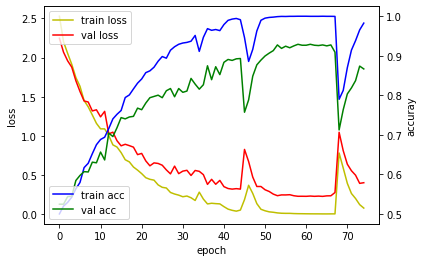

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [12]:
test_X=tf.reshape(np.array(test.iloc[:,2:]),[-1, 600, 6])
prediction=model.predict(test_X)
submission.iloc[:,1:]=prediction
submission.to_csv('aug_cnn3_bilstm2.csv', index=False)